# CUMCM2017 Problems B
本文主要讨论2017年国赛问题B的一些建模和解决方法。

**B题“拍照赚钱”的任务定价**

“拍照赚钱”是移动互联网下的一种自助式服务模式。用户下载APP，注册成为APP的会员，然后从APP上领取需要拍照的任务（比如上超市去检查某种商品的上架情况），赚取APP对任务所标定的酬金。这种基于移动互联网的自助式劳务众包平台，为企业提供各种商业检查和信息搜集，相比传统的市场调查方式可以大大节省调查成本，而且有效地保证了调查数据真实性，缩短了调查的周期。因此APP成为该平台运行的核心，而APP中的任务定价又是其核心要素。如果定价不合理，有的任务就会无人问津，而导致商品检查的失败。

附件一是一个已结束项目的任务数据，包含了每个任务的位置、定价和完成情况（“1”表示完成，“0”表示未完成）；附件二是会员信息数据，包含了会员的位置、信誉值、参考其信誉给出的任务开始预订时间和预订限额，原则上会员信誉越高，越优先开始挑选任务，其配额也就越大（任务分配时实际上是根据预订限额所占比例进行配发）；附件三是一个新的检查项目任务数据，只有任务的位置信息。请完成下面的问题：

* 1.研究附件一中项目的任务定价规律，分析任务未完成的原因。
* 2.为附件一中的项目设计新的任务定价方案，并和原方案进行比较。
* 3.实际情况下，多个任务可能因为位置比较集中，导致用户会争相选择，一种考虑是将这些任务联合在一起打包发布。在这种考虑下，如何修改前面的定价模型，对最终的任务完成情况又有什么影响？
* 4.对附件三中的新项目给出你的任务定价方案，并评价该方案的实施效果。

附件一：已结束项目任务数据 

附件二：会员信息数据 

附件三：新项目任务数据


## 1.数据预处理

In [32]:
import numpy as np
import pandas as pd
data1 = pd.read_csv('/data/CUMCM2017Problems/B_csv_doc/附件一：已结束项目任务数据.csv')
data1.head()

,任务号码,任务gps 纬度,任务gps经度,任务标价,任务执行情况
0,A0001,22.566142,113.980837,66.0,0
1,A0002,22.686205,113.940525,65.5,0
2,A0003,22.576512,113.957198,65.5,1
3,A0004,22.564841,114.244571,75.0,0
4,A0005,22.558888,113.950723,65.5,0


In [33]:
data2 = pd.read_csv('/data/CUMCM2017Problems/B_csv_doc/附件二：会员信息数据.csv')
data2.head()

,会员编号,会员位置(GPS),预订任务限额,预订任务开始时间,信誉值
0,B0001,22.947097 113.679983,114,6:30:00,67997.3868
1,B0002,22.577792 113.966524,163,6:30:00,37926.5416
2,B0003,23.192458 113.347272,139,6:30:00,27953.0363
3,B0004,23.255965 113.31875,98,6:30:00,25085.6986
4,B0005,33.65205 116.97047,66,6:30:00,20919.0667


In [34]:
data3 = pd.read_csv('/data/CUMCM2017Problems/B_csv_doc/附件三：新项目任务数据.csv')
data3.head()

,任务号码,任务GPS纬度,任务GPS经度
0,C0001,22.730041,114.240880
1,C0002,22.727043,114.299620
2,C0003,22.701311,114.233601
3,C0004,22.732359,114.286667
4,C0005,22.718391,114.257549


In [35]:
print(data1.shape,data2.shape,data3.shape)

(835, 5) (1877, 5) (2066, 3)


In [36]:
print('列表1缺失值：', data1.isnull().sum())
print('列表2缺失值：', data2.isnull().sum())
print('列表3缺失值：', data3.isnull().sum())

列表1缺失值： 任务号码        0
任务gps 纬度    0
任务gps经度     0
任务标价        0
任务执行情况      0
dtype: int64
列表2缺失值： 会员编号         0
会员位置(GPS)    0
预订任务限额       0
预订任务开始时间     0
信誉值          0
dtype: int64
列表3缺失值： 任务号码       0
任务GPS纬度    0
任务GPS经度    0
dtype: int64


### 1.1把data2中的会员位置(GPS)分离

In [37]:
# data2['会员位置(GPS)'].head()

In [38]:
t= []
for i in range(len(data2)):
    t.append(data2['会员位置(GPS)'][i].split(' '))

In [39]:
m1 = []
m2 = []
for j in range(len(t)):
    m1.append(float(t[j][0]))
for j in range(len(t)):
    m2.append(float(t[j][1]))

In [40]:
data2['会员纬度'] = m1
data2['会员经度'] = m2
# data2.head()

In [41]:
data2 = data2.reindex(columns = 
['会员编号','会员纬度','会员经度','预订任务限额','预订任务开始时间','信誉值'])
data2.head()

,会员编号,会员纬度,会员经度,预订任务限额,预订任务开始时间,信誉值
0,B0001,22.947097,113.679983,114,6:30:00,67997.3868
1,B0002,22.577792,113.966524,163,6:30:00,37926.5416
2,B0003,23.192458,113.347272,139,6:30:00,27953.0363
3,B0004,23.255965,113.318750,98,6:30:00,25085.6986
4,B0005,33.652050,116.970470,66,6:30:00,20919.0667


### 1.2 data2的时间转换
以6：00为开始时间，其他时间减6：00的秒数作为新数据。

In [42]:
import datetime
gap = []
for i in range(len(data2)):
    dt = datetime.datetime.strptime(data2['预订任务开始时间'][i],'%H:%M:%S')
    dt2 = datetime.datetime.strptime('6:00:00','%H:%M:%S') 
    delta = dt - dt2
    gap.append(delta.seconds)
gap = np.asarray(gap)
data2['预订任务开始时间'] = gap

In [43]:
data2.head(10)

,会员编号,会员纬度,会员经度,预订任务限额,预订任务开始时间,信誉值
0,B0001,22.947097,113.679983,114,1800,67997.3868
1,B0002,22.577792,113.966524,163,1800,37926.5416
2,B0003,23.192458,113.347272,139,1800,27953.0363
3,B0004,23.255965,113.318750,98,1800,25085.6986
4,B0005,33.652050,116.970470,66,1800,20919.0667
5,B0006,22.262784,112.797680,72,1800,18237.6295
6,B0007,29.560903,106.239083,15,1800,15729.3601
7,B0008,23.143373,113.376315,95,2520,14868.4446
8,B0009,23.285280,113.651842,110,2160,13556.1555
9,B0010,23.099259,113.488909,64,2160,13327.9511


### 1.3 会员与任务点的分布散点图

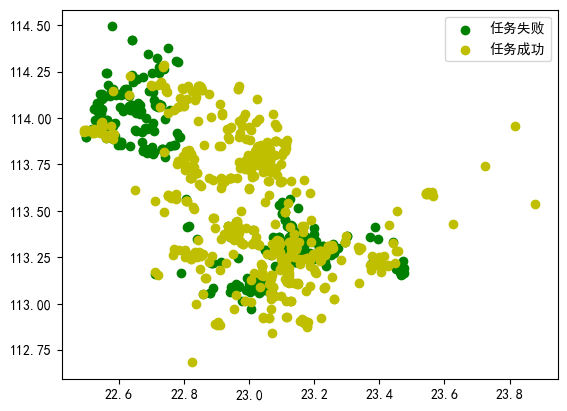

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False 

data1_0 = data1.loc[data1['任务执行情况'] == 0]
data1_1 = data1.loc[data1['任务执行情况'] == 1]

plt.scatter(data1_0['任务gps 纬度'], data1_0['任务gps经度'], color='g', label = '任务失败')
plt.scatter(data1_1['任务gps 纬度'], data1_1['任务gps经度'], color='y', label = '任务成功')
plt.legend()
plt.show()

In [14]:
#plt.scatter(data2['会员纬度'], data2['会员经度'], color = 'g', label = '会员')
#plt.legend()
#plt.show()

In [15]:
# data2.loc[data2['会员纬度']>60]

In [45]:
data2.iloc[1174,1] = 23.031824
data2.iloc[1174,2] = 113.131483

In [46]:
#plt.scatter(data1['任务gps 纬度'], data1['任务gps经度'], color = 'r',label = '任务')
#plt.scatter(data2['会员纬度'], data2['会员经度'], color = 'g', marker = 'x',label = '会员')
#plt.legend()
#plt.show()

In [47]:
# data2.loc[data2['会员纬度']>26]

In [48]:
data2_1 = data2.drop([4,6,21],axis = 0)

In [49]:
# data2_1.head(30)

In [50]:
#plt.scatter(data2_1['会员纬度'], data2_1['会员经度'], color = 'g', marker = 'x',label = '会员')
#plt.scatter(data1['任务gps 纬度'], data1['任务gps经度'], color = 'r',marker = '+',label = '任务')
#plt.legend()
#plt.show()

In [51]:
# data2.loc[data2['会员纬度']<22]

In [52]:
data2_1.drop([38,47,81,471,1726],axis = 0,inplace = True)

In [53]:
# data2_1.loc[data2_1['会员纬度']>24]

In [54]:
data2_1.drop([135,1707],axis = 0,inplace = True)

In [55]:
# data2_1.shape

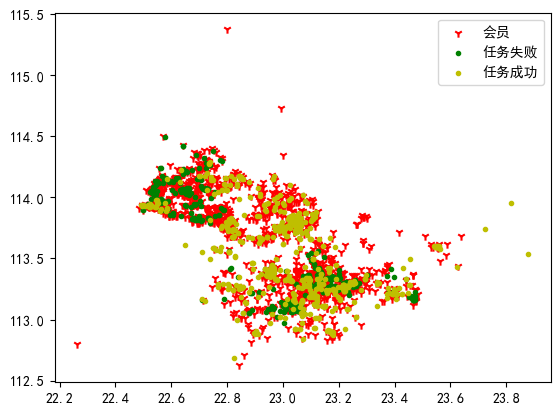

In [56]:
plt.scatter(data2_1['会员纬度'], data2_1['会员经度'], color = 'r', marker = '1',label = '会员')
plt.scatter(data1_0['任务gps 纬度'], data1_0['任务gps经度'], color='g', marker = '.',label = '任务失败')
plt.scatter(data1_1['任务gps 纬度'], data1_1['任务gps经度'], color='y', marker ='.', label ='任务成功')
plt.legend()
plt.show()

## 2.建模思路
**一些简单的推理:**
* 从题目可以知道会员的信誉值会正比的影响预订任务限额和预订任务开始时间。一般来说，信誉值越高，预定任务限额越高，任务开始时间越早，但从数据上看显然并不是绝对的。
* 从图可以看到，任务是否成功显然不和会员的密度有关，因为会员聚集的地方也有成功/失败的例子。
* 从图可以看到，任务成功的原因可能与会员的信誉值有关，进而跟会员的任务分配额度，任务开始时间有关。
* 从而我们假设：一个任务点附近的会员的信誉值越高（会员的任务分配额度越高，任务开始时间越早），这个会员离任务点越近，则任务成功率越高。


任务点的经纬度设为$(a_i,b_i),i = 1,\cdots,n$，任务定价为$p_i$，任务成功与否设为$s_i$。会员经纬度设为$(x_j,y_j),j = 1,\cdots,m$，预定任务配额$m_j$，开始时间$t_j$，信誉值$c_j$.

### 问题1：类似k近邻的建模算法：
每一个任务点x周围选取k个距离最近的会员，假设距离从小到大分别为$dis_1,\cdots,dis_k$，距离倒数为$Dis_{ij} = 1/dis_{ij}$，注意这里的坐标是经纬度，所以要用经纬度计算距离的公式。

希望实现：距离越近，权重越大。

这k个会员的预定任务配额$m_j$，开始时间$t_j$，信誉值$c_j$，$j = 1,\cdots , k$。

构建3个量:
* 任务点加权预订任务配额 $ M_i = \frac{Dis_{1}}{(Dis_{1}+\cdots+dis_k)} * m_1 + \frac{Dis_{2}}{(Dis_{1}+\cdots+Dis_k)} * m_2 + \cdots + \frac{Dis_{k}}{(Dis_{k}+\cdots+Dis_k)} * m_k$
* 任务点加权会员预订开始时间 $ C_i = \frac{Dis_{1}}{(Dis_{1}+\cdots+dis_k)} * c_1 + \frac{Dis_{2}}{(Dis_{1}+\cdots+Dis_k)} * c_2 + \cdots + \frac{Dis_{k}}{(Dis_{k}+\cdots+Dis_k)} * c_k$
* 任务点加权会员信誉值 $ T_i = \frac{Dis_{1}}{(Dis_{1}+\cdots+dis_k)} * t_1 + \frac{Dis_{2}}{(Dis_{1}+\cdots+Dis_k)} * t_2 + \cdots + \frac{Dis_{k}}{(Dis_{k}+\cdots+Dis_k)} * t_k$

所以特征有**任务点加权预订任务配额**，**任务点加权会员预订开始时间**，**任务点加权会员信誉值**，**任务标价**，而**任务执行情况**作为标签集。整个问题转化为分类问题。

### 问题2：定价问题
类似问题1的建模，但是是以定价为标签集的回归问题。

### 问题3：打包问题
选定一定的半径长度，选定一些任务点作为中心，半径内的任务全部加权打包起来，再计算成本。